In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Set consistent color palette and style for all visualizations
plt.style.use('default')
colors = {
    'emotional': '#FF6B6B',     # Coral red for emotional variables
    'workplace': '#4ECDC4',     # Teal for workplace variables  
    'implicit': '#95A5A6',      # Gray for implicit/fast choice
    'explicit': '#2C3E50',      # Dark blue for explicit/Likert
    'primary': '#3498DB',       # Blue for primary elements
    'secondary': '#E74C3C',     # Red for secondary elements
    'accent': '#F39C12'         # Orange for accents
}

# Configure matplotlib for consistent styling
plt.rcParams.update({
    'font.size': 11,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.titlesize': 16
})

# Load the dataset with factor analysis results
data = pd.read_pickle('../data/survey_data_with_factors.pkl')

print(f"Dataset shape: {data.shape}")
print(f"Using dataset with factor analysis results")

# Define preparedness variables (our target)
preparedness_vars = ['es_fgen', 'el_lgen']  # Fast choice and Likert versions

# Define emotional predictors 
emotional_fast = [col for col in data.columns if col.startswith('es_') and col != 'es_fgen']
emotional_likert = [col for col in data.columns if col.startswith('el_') and col != 'el_lgen']

# Define workplace predictors
workplace_fast = [col for col in data.columns if col.startswith('wfs_')]
workplace_likert = [col for col in data.columns if col.startswith('wfl_')]

# Check for factor variables
factor_vars = [col for col in data.columns if 'factor' in col.lower()]
print(f"\nFactor variables available: {len(factor_vars)}")
print(f"Factor variable types: {factor_vars[:10]}...")  # Show first 10

print(f"\nEmotional fast choice variables: {len(emotional_fast)}")
print(f"Emotional Likert variables: {len(emotional_likert)}")
print(f"Workplace fast choice variables: {len(workplace_fast)}")
print(f"Workplace Likert variables: {len(workplace_likert)}")

Dataset shape: (4211, 97)
Using dataset with factor analysis results

Factor variables available: 28
Factor variable types: ['combined_factor_1', 'combined_factor_2', 'combined_factor_3', 'combined_factor_4', 'combined_factor_5', 'fast_factor_1', 'fast_factor_2', 'fast_factor_3', 'fast_factor_4', 'fast_factor_5']...

Emotional fast choice variables: 14
Emotional Likert variables: 14
Workplace fast choice variables: 11
Workplace Likert variables: 11


In [2]:
# Enhanced name mappings with visual coding for professional presentation
# Stars (★) for emotional variables, diamonds (◆) for workplace variables
emotional_names = {
    'es_fgen': '★ Ready for next step',
    'es_ftra_des': '★ Want new start', 
    'es_ftra_aut': '★ Freedom to change',
    'es_fcnt_com': '★ Comfortable where I am',
    'es_fcnt_psy': '★ Voice is heard',
    'es_fcon_soc': '★ Others influence decisions',
    'es_fbal_anx': '★ Anxious about change',
    'es_fres_fin': '★ Financially motivated',
    'es_fcont_imp': '★ Believe in myself',
    'es_fjou_opt': '★ Optimistic about future',
    'es_fcon_inc': '★ Feel included',
    'es_fbal_sat': '★ Happy where I am',
    'es_fres_ski': '★ Skills to progress',
    'es_fcont_con': '★ Control next step',
    'es_fjou_pro': '★ Set myself goals',
    'el_lgen': '★ Ready for next step (L)',
    'el_ltra_des': '★ Want new start (L)',
    'el_ltra_aut': '★ Freedom to change (L)', 
    'el_lcnt_com': '★ Comfortable where I am (L)',
    'el_lcnt_psy': '★ Voice is heard (L)',
    'el_lcon_soc': '★ Others influence decisions (L)',
    'el_lbal_anx': '★ Anxious about change (L)',
    'el_lres_fin': '★ Financially motivated (L)',
    'el_lcont_imp': '★ Believe in myself (L)',
    'el_ljou_opt': '★ Optimistic about future (L)',
    'el_lcon_inc': '★ Feel included (L)',
    'el_lbal_sat': '★ Happy where I am (L)',
    'el_lres_ski': '★ Skills to progress (L)',
    'el_lcont_con': '★ Control next step (L)',
    'el_ljou_pro': '★ Set myself goals (L)'
}

workplace_names = {
    'wfs_fuse_skills': '◆ Can use skills',
    'wfs_flearn_dev': '◆ Learning opportunities',
    'wfs_fcarprom': '◆ Can grow here',
    'wfs_fmean_full': '◆ Job meaningful',
    'wfs_fpoorman': '◆ Manager is poor',
    'wfs_ftoxic': '◆ Culture is toxic',
    'wfs_fexcess_wk': '◆ Working too hard',
    'wfs_fcollea': '◆ Don\'t get along with colleagues',
    'wfs_fwellcomp': '◆ Well compensated',
    'wfs_ffin_fair': '◆ Salary unfair vs colleagues',
    'wfs_fenjhyb': '◆ Enjoy hybrid working',
    'wfl_luse_skills': '◆ Can use skills (L)',
    'wfl_llearn_dev': '◆ Learning opportunities (L)',
    'wfl_lcarprom_d': '◆ Can grow here (L)',
    'wfl_lmean_full': '◆ Job meaningful (L)',
    'wfl_lpoorman': '◆ Manager is poor (L)',
    'wfl_ltoxic': '◆ Culture is toxic (L)',
    'wfl_lexcess_wk': '◆ Working too hard (L)',
    'wfl_lcollea': '◆ Don\'t get along with colleagues (L)',
    'wfl_lwellcomp': '◆ Well compensated (L)',
    'wfl_lfin_lair': '◆ Salary unfair vs colleagues (L)',
    'wfl_lenjhyb': '◆ Enjoy hybrid working (L)'
}

# Combine all names
all_names = {**emotional_names, **workplace_names}

print("Variable naming system configured with visual coding:")
print("★ = Emotional variables")
print("◆ = Workplace variables") 
print("(L) = Likert scale version")
print(f"Total mapped variables: {len(all_names)}")

Variable naming system configured with visual coding:
★ = Emotional variables
◆ = Workplace variables
(L) = Likert scale version
Total mapped variables: 52


In [3]:
# Calculate correlations with career preparedness index (prep_level)
all_predictors = emotional_fast + emotional_likert + workplace_fast + workplace_likert

# Correlations with career preparedness index (0-10 scale)
prep_correlations = data[all_predictors + ['prep_level']].corr()['prep_level'].drop('prep_level')

# Create summary dataframe
corr_summary = pd.DataFrame({
    'Variable': prep_correlations.index,
    'Correlation': prep_correlations.values,
    'Abs_Correlation': prep_correlations.abs().values,
    'Variable_Type': ['Emotional' if var.startswith(('es_', 'el_')) else 'Workplace' 
                      for var in prep_correlations.index],
    'Response_Type': ['Fast_Choice' if var.startswith(('es_', 'wfs_')) else 'Likert' 
                      for var in prep_correlations.index]
})

# Add readable names
corr_summary['Readable_Name'] = corr_summary['Variable'].map(all_names)

# Sort by absolute correlation strength
corr_summary = corr_summary.sort_values('Abs_Correlation', ascending=False)

print("Top 10 Most Predictive Factors (Career Preparedness Index):")
print(corr_summary[['Readable_Name', 'Variable_Type', 'Correlation']].head(10))

Top 10 Most Predictive Factors (Career Preparedness Index):
                    Readable_Name Variable_Type  Correlation
25       ★ Skills to progress (L)     Emotional     0.567131
21        ★ Believe in myself (L)     Emotional     0.522312
23         ★ Set myself goals (L)     Emotional     0.517007
26        ★ Freedom to change (L)     Emotional     0.515318
20        ★ Control next step (L)     Emotional     0.493985
17           ★ Voice is heard (L)     Emotional     0.427232
22  ★ Optimistic about future (L)     Emotional     0.416261
27           ★ Want new start (L)     Emotional     0.385475
7             ★ Believe in myself     Emotional     0.383003
18            ★ Feel included (L)     Emotional     0.379637


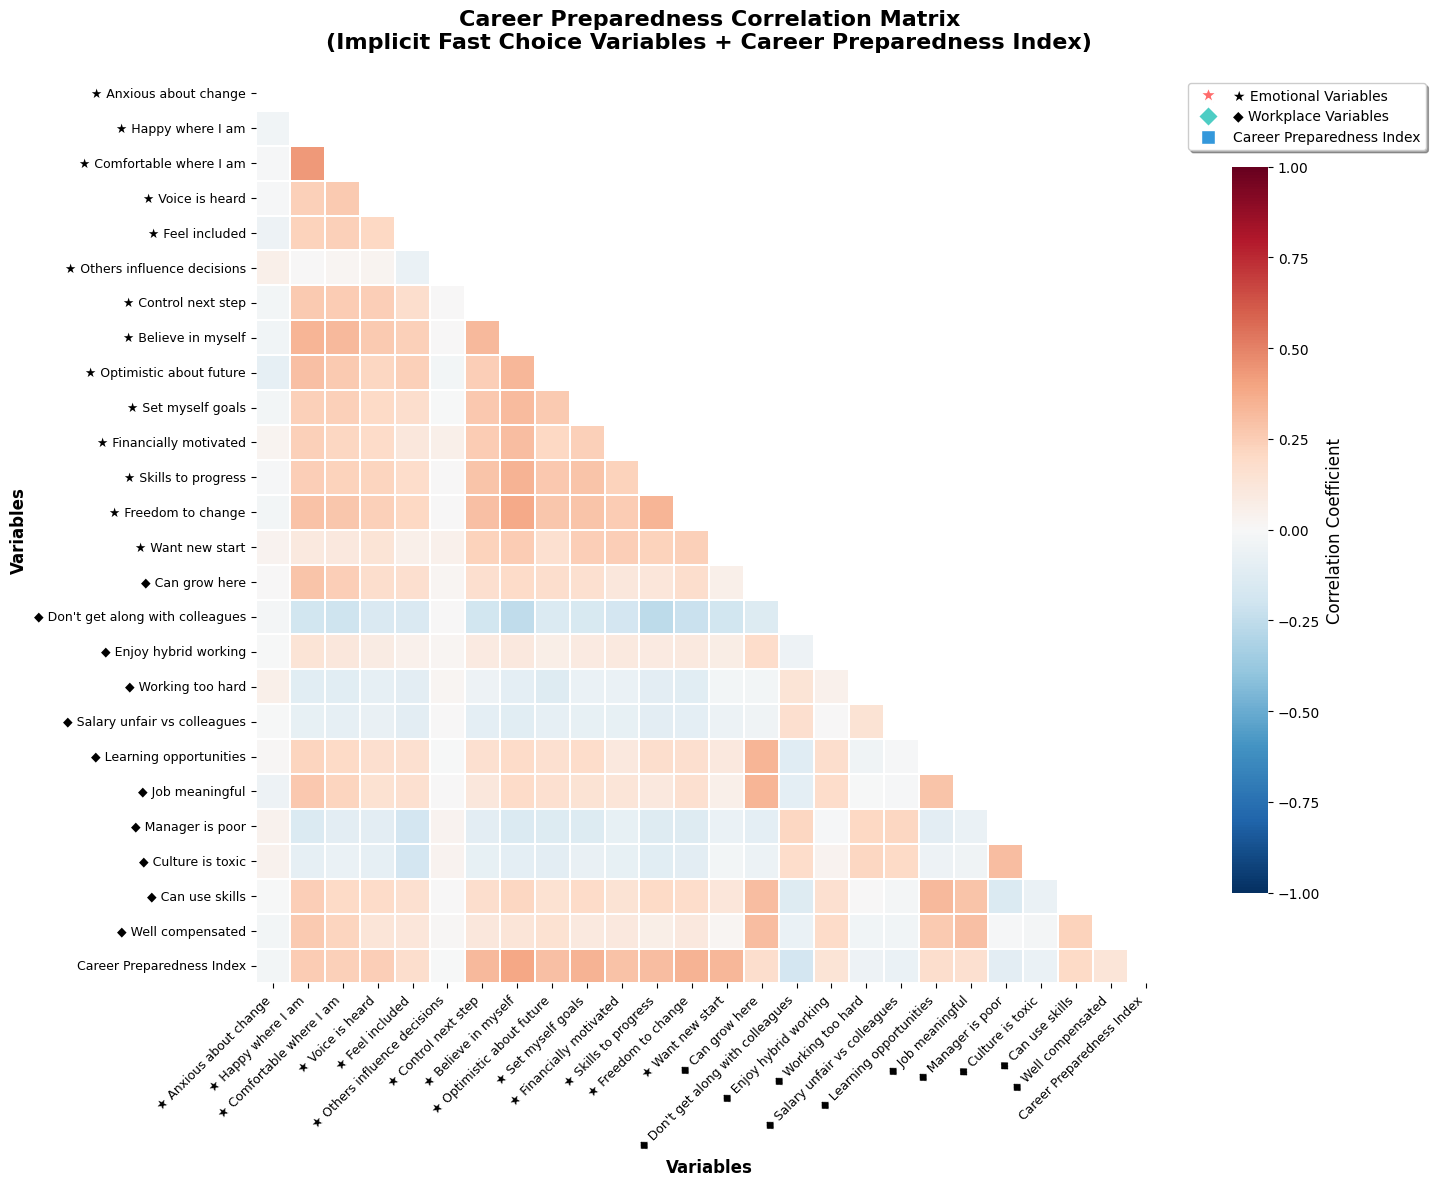

Correlation Matrix Summary:
Mean absolute correlation: 0.147
Strongest correlation: 0.432
Correlations > 0.5: 0 out of 325
Note: Matrix includes correlations with Career Preparedness Index (prep_level)


In [4]:
# Create correlation matrix for visualization
predictor_vars = emotional_fast + workplace_fast  # Focus on fast choice for clarity
prep_corr_matrix = data[predictor_vars + ['prep_level']].corr()

# Add prep_level to names for visualization
all_names_with_prep = all_names.copy()
all_names_with_prep['prep_level'] = 'Career Preparedness Index'

# Rename for visualization
prep_corr_renamed = prep_corr_matrix.rename(index=all_names_with_prep, columns=all_names_with_prep)

# Create heatmap with consistent styling
fig, ax = plt.subplots(figsize=(16, 12))
mask = np.triu(np.ones_like(prep_corr_renamed, dtype=bool))  # Show only lower triangle

# Use a professional color scheme
sns.heatmap(prep_corr_renamed, annot=False, cmap="RdBu_r", square=True, 
           cbar_kws={"shrink": .8, "label": "Correlation Coefficient"}, 
           vmin=-1, vmax=1, ax=ax, mask=mask, linewidths=0.1)

ax.set_title("Career Preparedness Correlation Matrix\n(Implicit Fast Choice Variables + Career Preparedness Index)", 
             fontsize=16, pad=20, fontweight='bold')
ax.set_xlabel('Variables', fontsize=12, fontweight='bold')
ax.set_ylabel('Variables', fontsize=12, fontweight='bold')

# Improve tick label formatting
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=9)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=9)

# Add custom legend with proper symbols
legend_elements = [
    plt.Line2D([0], [0], marker='*', color='w', markerfacecolor=colors['emotional'], 
               markersize=12, label='★ Emotional Variables'),
    plt.Line2D([0], [0], marker='D', color='w', markerfacecolor=colors['workplace'], 
               markersize=10, label='◆ Workplace Variables'),
    plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=colors['primary'], 
               markersize=10, label='Career Preparedness Index')
]
ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.02, 1), 
          frameon=True, fancybox=True, shadow=True)

plt.tight_layout()
plt.show()

# Display correlation strength summary
corr_values = prep_corr_matrix.values[np.tril_indices_from(prep_corr_matrix.values, k=-1)]
print("Correlation Matrix Summary:")
print(f"Mean absolute correlation: {np.abs(corr_values).mean():.3f}")
print(f"Strongest correlation: {np.abs(corr_values).max():.3f}")
print(f"Correlations > 0.5: {np.sum(np.abs(corr_values) > 0.5)} out of {len(corr_values)}")
print(f"Note: Matrix includes correlations with Career Preparedness Index (prep_level)")

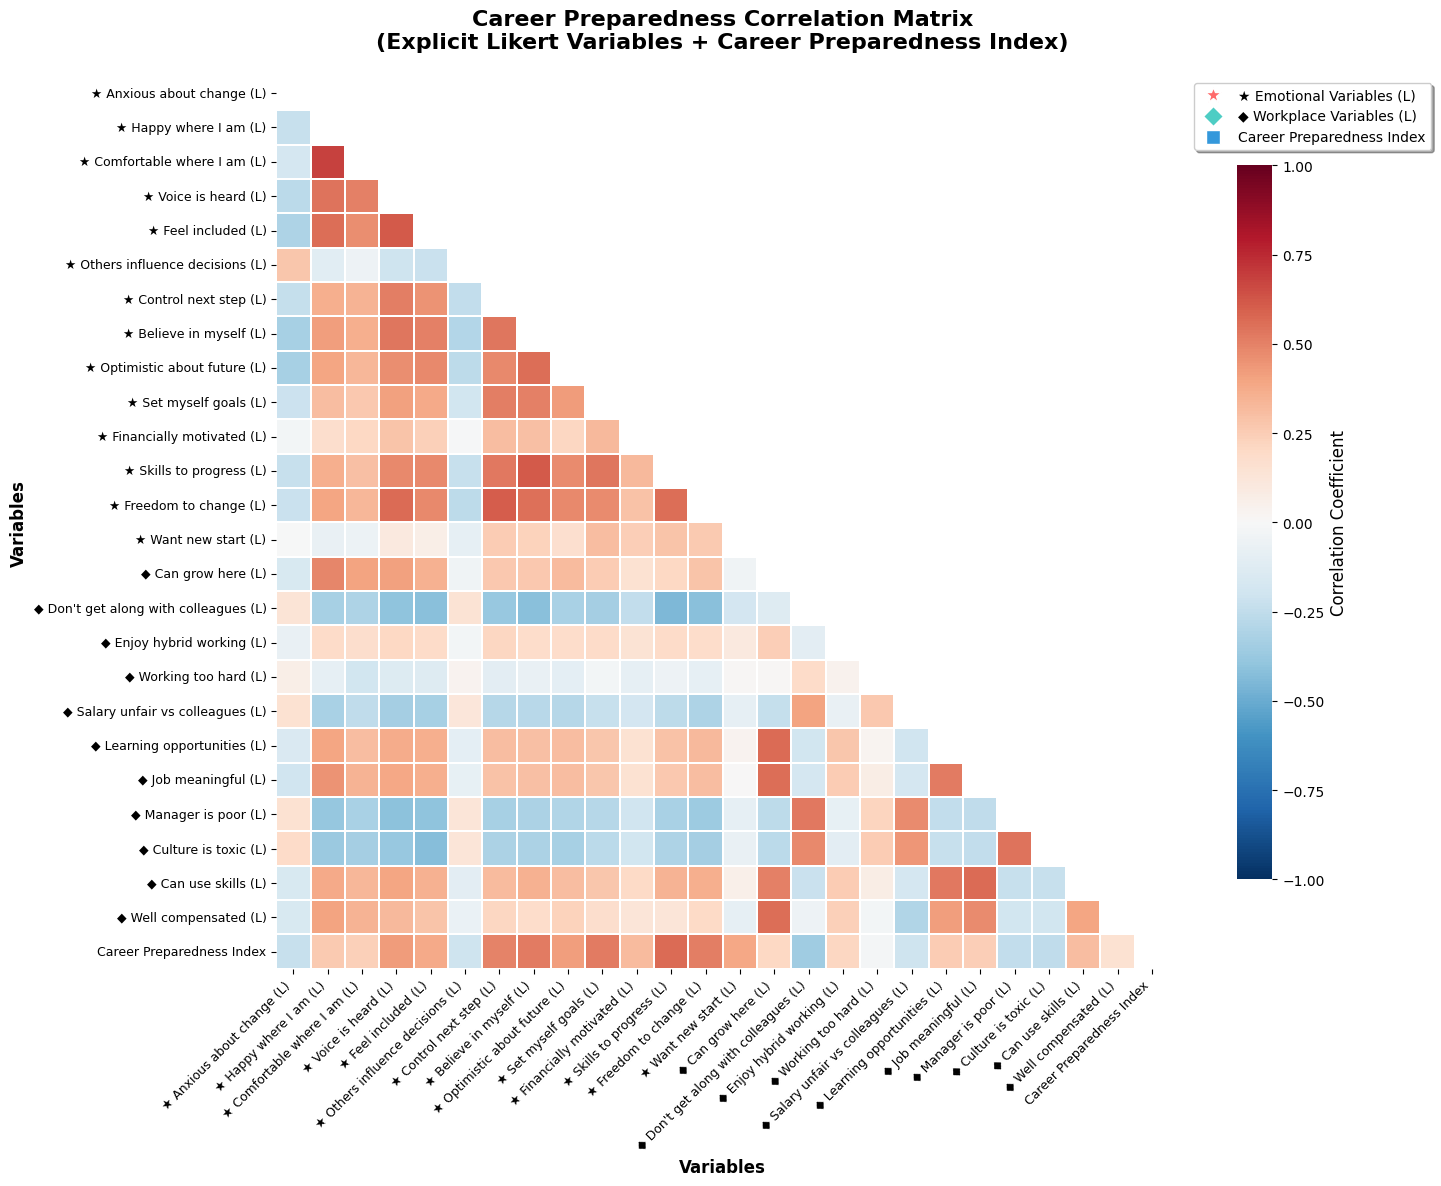

Likert Variables Correlation Matrix Summary:
Mean absolute correlation: 0.281
Strongest correlation: 0.681
Correlations > 0.5: 32 out of 325
Note: Matrix includes correlations with Career Preparedness Index (prep_level)


In [5]:
# Create correlation matrix for Likert (explicit) variables
likert_vars = emotional_likert + workplace_likert  # Focus on Likert variables
likert_corr_matrix = data[likert_vars + ['prep_level']].corr()

# Add prep_level to names for visualization
all_names_with_prep_likert = all_names.copy()
all_names_with_prep_likert['prep_level'] = 'Career Preparedness Index'

# Rename for visualization
likert_corr_renamed = likert_corr_matrix.rename(index=all_names_with_prep_likert, columns=all_names_with_prep_likert)

# Create heatmap with consistent styling
fig, ax = plt.subplots(figsize=(16, 12))
mask = np.triu(np.ones_like(likert_corr_renamed, dtype=bool))  # Show only lower triangle

# Use a professional color scheme
sns.heatmap(likert_corr_renamed, annot=False, cmap="RdBu_r", square=True, 
           cbar_kws={"shrink": .8, "label": "Correlation Coefficient"}, 
           vmin=-1, vmax=1, ax=ax, mask=mask, linewidths=0.1)

ax.set_title("Career Preparedness Correlation Matrix\n(Explicit Likert Variables + Career Preparedness Index)", 
             fontsize=16, pad=20, fontweight='bold')
ax.set_xlabel('Variables', fontsize=12, fontweight='bold')
ax.set_ylabel('Variables', fontsize=12, fontweight='bold')

# Improve tick label formatting
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=9)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=9)

# Add custom legend with proper symbols
legend_elements = [
    plt.Line2D([0], [0], marker='*', color='w', markerfacecolor=colors['emotional'], 
               markersize=12, label='★ Emotional Variables (L)'),
    plt.Line2D([0], [0], marker='D', color='w', markerfacecolor=colors['workplace'], 
               markersize=10, label='◆ Workplace Variables (L)'),
    plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=colors['primary'], 
               markersize=10, label='Career Preparedness Index')
]
ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.02, 1), 
          frameon=True, fancybox=True, shadow=True)

plt.tight_layout()
plt.show()

# Display correlation strength summary
likert_corr_values = likert_corr_matrix.values[np.tril_indices_from(likert_corr_matrix.values, k=-1)]
print("Likert Variables Correlation Matrix Summary:")
print(f"Mean absolute correlation: {np.abs(likert_corr_values).mean():.3f}")
print(f"Strongest correlation: {np.abs(likert_corr_values).max():.3f}")
print(f"Correlations > 0.5: {np.sum(np.abs(likert_corr_values) > 0.5)} out of {len(likert_corr_values)}")
print(f"Note: Matrix includes correlations with Career Preparedness Index (prep_level)")

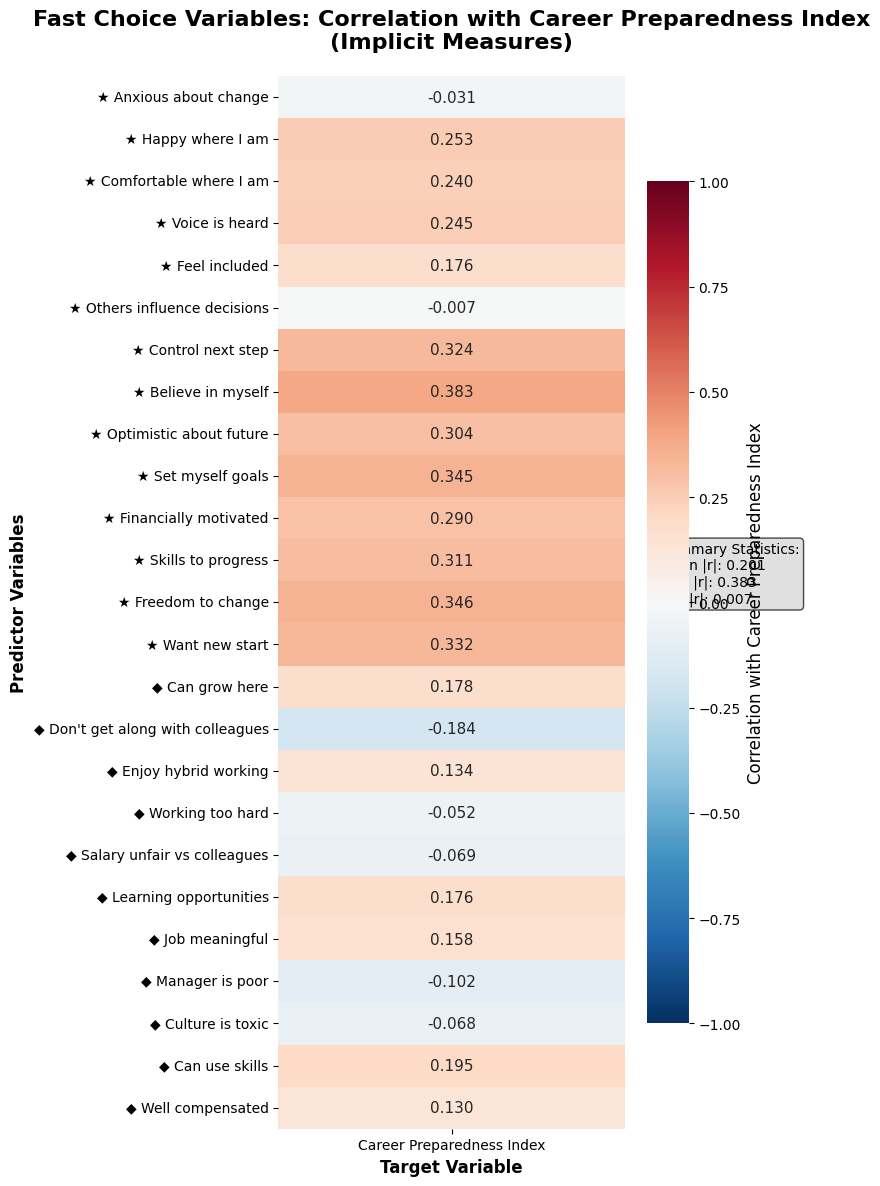

Fast Choice Variables - Correlations with Career Preparedness Index (prep_level):
Strongest positive correlation: 0.383
Strongest negative correlation: -0.184
Mean absolute correlation: 0.201


In [6]:
# Create focused heatmap showing Fast Choice variables' correlations with Career Preparedness Index
fast_predictors_analysis = emotional_fast + workplace_fast
fast_prep_correlations = data[fast_predictors_analysis + ['prep_level']].corr()[['prep_level']]

# Create a horizontal heatmap showing correlations with prep_level
fig, ax = plt.subplots(figsize=(8, 12))

# Get correlations with prep_level (excluding prep_level itself)
fast_prep_corr_values = fast_prep_correlations.drop('prep_level')

# Create readable names for variables
fast_readable_names = [all_names[var] for var in fast_prep_corr_values.index]

# Create horizontal heatmap
sns.heatmap(fast_prep_corr_values.values.reshape(-1, 1), 
           annot=True, fmt='.3f', cmap="RdBu_r", center=0,
           cbar_kws={"shrink": .8, "label": "Correlation with Career Preparedness Index"}, 
           vmin=-1, vmax=1, ax=ax, 
           yticklabels=fast_readable_names,
           xticklabels=['Career Preparedness Index'])

ax.set_title("Fast Choice Variables: Correlation with Career Preparedness Index\n(Implicit Measures)", 
             fontsize=16, pad=20, fontweight='bold')
ax.set_xlabel('Target Variable', fontsize=12, fontweight='bold')
ax.set_ylabel('Predictor Variables', fontsize=12, fontweight='bold')

# Improve tick label formatting
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)

# Add summary statistics
prep_corr_stats = fast_prep_corr_values['prep_level'].abs()
ax.text(1.1, 0.5, f'Summary Statistics:\nMean |r|: {prep_corr_stats.mean():.3f}\nMax |r|: {prep_corr_stats.max():.3f}\nMin |r|: {prep_corr_stats.min():.3f}', 
        transform=ax.transAxes, fontsize=10, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.7))

plt.tight_layout()
plt.show()

print(f"Fast Choice Variables - Correlations with Career Preparedness Index (prep_level):")
print(f"Strongest positive correlation: {fast_prep_corr_values['prep_level'].max():.3f}")
print(f"Strongest negative correlation: {fast_prep_corr_values['prep_level'].min():.3f}")
print(f"Mean absolute correlation: {fast_prep_corr_values['prep_level'].abs().mean():.3f}")

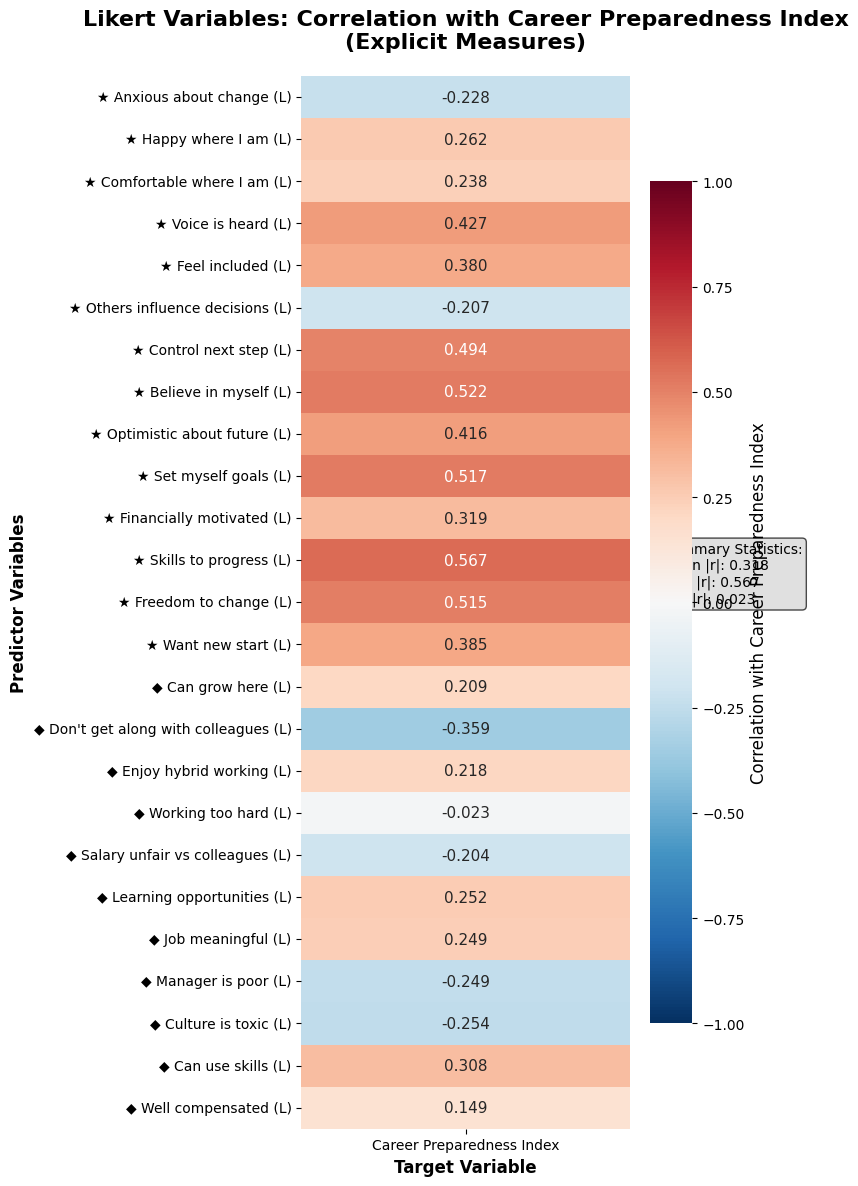

Likert Variables - Correlations with Career Preparedness Index (prep_level):
Strongest positive correlation: 0.567
Strongest negative correlation: -0.359
Mean absolute correlation: 0.318


In [7]:
# Create focused heatmap showing Likert variables' correlations with Career Preparedness Index
likert_predictors_analysis = emotional_likert + workplace_likert
likert_prep_correlations = data[likert_predictors_analysis + ['prep_level']].corr()[['prep_level']]

# Create a horizontal heatmap showing correlations with prep_level
fig, ax = plt.subplots(figsize=(8, 12))

# Get correlations with prep_level (excluding prep_level itself)
likert_prep_corr_values = likert_prep_correlations.drop('prep_level')

# Create readable names for variables
likert_readable_names = [all_names[var] for var in likert_prep_corr_values.index]

# Create horizontal heatmap
sns.heatmap(likert_prep_corr_values.values.reshape(-1, 1), 
           annot=True, fmt='.3f', cmap="RdBu_r", center=0,
           cbar_kws={"shrink": .8, "label": "Correlation with Career Preparedness Index"}, 
           vmin=-1, vmax=1, ax=ax, 
           yticklabels=likert_readable_names,
           xticklabels=['Career Preparedness Index'])

ax.set_title("Likert Variables: Correlation with Career Preparedness Index\n(Explicit Measures)", 
             fontsize=16, pad=20, fontweight='bold')
ax.set_xlabel('Target Variable', fontsize=12, fontweight='bold')
ax.set_ylabel('Predictor Variables', fontsize=12, fontweight='bold')

# Improve tick label formatting
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)

# Add summary statistics
likert_prep_corr_stats = likert_prep_corr_values['prep_level'].abs()
ax.text(1.1, 0.5, f'Summary Statistics:\nMean |r|: {likert_prep_corr_stats.mean():.3f}\nMax |r|: {likert_prep_corr_stats.max():.3f}\nMin |r|: {likert_prep_corr_stats.min():.3f}', 
        transform=ax.transAxes, fontsize=10, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.7))

plt.tight_layout()
plt.show()

print(f"Likert Variables - Correlations with Career Preparedness Index (prep_level):")
print(f"Strongest positive correlation: {likert_prep_corr_values['prep_level'].max():.3f}")
print(f"Strongest negative correlation: {likert_prep_corr_values['prep_level'].min():.3f}")
print(f"Mean absolute correlation: {likert_prep_corr_values['prep_level'].abs().mean():.3f}")

In [8]:
# Correlation analysis for Likert (explicit) variables with Career Preparedness Index
likert_predictors = emotional_likert + workplace_likert

# Correlations with career preparedness index (0-10 scale)
prep_correlations_likert = data[likert_predictors + ['prep_level']].corr()['prep_level'].drop('prep_level')

# Create summary dataframe for Likert variables
corr_summary_likert = pd.DataFrame({
    'Variable': prep_correlations_likert.index,
    'Correlation': prep_correlations_likert.values,
    'Abs_Correlation': prep_correlations_likert.abs().values,
    'Variable_Type': ['Emotional' if var.startswith('el_') else 'Workplace' 
                      for var in prep_correlations_likert.index],
    'Response_Type': 'Likert'
})

# Add readable names
corr_summary_likert['Readable_Name'] = corr_summary_likert['Variable'].map(all_names)

# Sort by absolute correlation strength
corr_summary_likert = corr_summary_likert.sort_values('Abs_Correlation', ascending=False)

print("Top 10 Likert (Explicit) Predictors of Career Preparedness:")
print(corr_summary_likert[['Readable_Name', 'Variable_Type', 'Correlation']].head(10))

Top 10 Likert (Explicit) Predictors of Career Preparedness:
                            Readable_Name Variable_Type  Correlation
11               ★ Skills to progress (L)     Emotional     0.567131
7                 ★ Believe in myself (L)     Emotional     0.522312
9                  ★ Set myself goals (L)     Emotional     0.517007
12                ★ Freedom to change (L)     Emotional     0.515318
6                 ★ Control next step (L)     Emotional     0.493985
3                    ★ Voice is heard (L)     Emotional     0.427232
8           ★ Optimistic about future (L)     Emotional     0.416261
13                   ★ Want new start (L)     Emotional     0.385475
4                     ★ Feel included (L)     Emotional     0.379637
15  ◆ Don't get along with colleagues (L)     Workplace    -0.359021


In [9]:
# Correlation analysis for Fast Choice (implicit) variables with Career Preparedness Index
fast_predictors = emotional_fast + workplace_fast

# Correlations with career preparedness index (0-10 scale)
prep_correlations_fast = data[fast_predictors + ['prep_level']].corr()['prep_level'].drop('prep_level')

# Create summary dataframe for Fast Choice variables
corr_summary_fast = pd.DataFrame({
    'Variable': prep_correlations_fast.index,
    'Correlation': prep_correlations_fast.values,
    'Abs_Correlation': prep_correlations_fast.abs().values,
    'Variable_Type': ['Emotional' if var.startswith('es_') else 'Workplace' 
                      for var in prep_correlations_fast.index],
    'Response_Type': 'Fast_Choice'
})

# Add readable names
corr_summary_fast['Readable_Name'] = corr_summary_fast['Variable'].map(all_names)

# Sort by absolute correlation strength
corr_summary_fast = corr_summary_fast.sort_values('Abs_Correlation', ascending=False)

print("Top 10 Fast Choice (Implicit) Predictors of Career Preparedness:")
print(corr_summary_fast[['Readable_Name', 'Variable_Type', 'Correlation']].head(10))

Top 10 Fast Choice (Implicit) Predictors of Career Preparedness:
                Readable_Name Variable_Type  Correlation
7         ★ Believe in myself     Emotional     0.383003
12        ★ Freedom to change     Emotional     0.345566
9          ★ Set myself goals     Emotional     0.344908
13           ★ Want new start     Emotional     0.331885
6         ★ Control next step     Emotional     0.323942
11       ★ Skills to progress     Emotional     0.311016
8   ★ Optimistic about future     Emotional     0.304445
10    ★ Financially motivated     Emotional     0.289979
1          ★ Happy where I am     Emotional     0.253172
3            ★ Voice is heard     Emotional     0.244908


In [10]:
# Compare Fast Choice vs Likert correlations with Career Preparedness Index
print("=== COMPARISON: FAST CHOICE vs LIKERT PREDICTIVE POWER ===\n")

# Calculate mean absolute correlations by response type
fast_mean_corr = corr_summary_fast['Abs_Correlation'].mean()
likert_mean_corr = corr_summary_likert['Abs_Correlation'].mean()

print(f"Fast Choice (Implicit) - Mean |correlation| with prep_level: {fast_mean_corr:.3f}")
print(f"Likert (Explicit) - Mean |correlation| with prep_level: {likert_mean_corr:.3f}")
print(f"Difference (Likert - Fast Choice): {likert_mean_corr - fast_mean_corr:.3f}")

# Top predictors from each method
print(f"\nStrongest Fast Choice predictor: {corr_summary_fast.iloc[0]['Readable_Name']} (r = {corr_summary_fast.iloc[0]['Correlation']:.3f})")
print(f"Strongest Likert predictor: {corr_summary_likert.iloc[0]['Readable_Name']} (r = {corr_summary_likert.iloc[0]['Correlation']:.3f})")

# Breakdown by variable type
print(f"\n=== BY VARIABLE TYPE ===")
for var_type in ['Emotional', 'Workplace']:
    fast_subset = corr_summary_fast[corr_summary_fast['Variable_Type'] == var_type]['Abs_Correlation'].mean()
    likert_subset = corr_summary_likert[corr_summary_likert['Variable_Type'] == var_type]['Abs_Correlation'].mean()
    
    if not pd.isna(fast_subset) and not pd.isna(likert_subset):
        print(f"{var_type} - Fast Choice: {fast_subset:.3f}, Likert: {likert_subset:.3f}, Difference: {likert_subset - fast_subset:.3f}")

=== COMPARISON: FAST CHOICE vs LIKERT PREDICTIVE POWER ===

Fast Choice (Implicit) - Mean |correlation| with prep_level: 0.201
Likert (Explicit) - Mean |correlation| with prep_level: 0.318
Difference (Likert - Fast Choice): 0.117

Strongest Fast Choice predictor: ★ Believe in myself (r = 0.383)
Strongest Likert predictor: ★ Skills to progress (L) (r = 0.567)

=== BY VARIABLE TYPE ===
Emotional - Fast Choice: 0.256, Likert: 0.391, Difference: 0.135
Workplace - Fast Choice: 0.132, Likert: 0.225, Difference: 0.093


In [11]:
# Use Random Forest to identify most important predictors of Career Preparedness Index
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

# Prepare data - remove missing values
analysis_data = data[all_predictors + ['prep_level']].dropna()
X = analysis_data[all_predictors]
y = analysis_data['prep_level']  # Career Preparedness Index (0-10 scale)

print(f"Training Random Forest on {len(analysis_data)} complete observations")
print(f"Target: Career Preparedness Index (prep_level, 0-10 scale)")
print(f"Mean preparedness level: {y.mean():.2f} (SD: {y.std():.2f})")

# Fit Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10)
rf.fit(X, y)

# Cross-validation performance
cv_scores = cross_val_score(rf, X, y, cv=5, scoring='r2')

# Get feature importance
feature_importance = pd.DataFrame({
    'Variable': all_predictors,
    'Importance': rf.feature_importances_,
    'Variable_Type': ['Emotional' if var.startswith(('es_', 'el_')) else 'Workplace' 
                      for var in all_predictors],
    'Response_Type': ['Fast_Choice' if var.startswith(('es_', 'wfs_')) else 'Likert' 
                      for var in all_predictors]
})

feature_importance['Readable_Name'] = feature_importance['Variable'].map(all_names)
feature_importance = feature_importance.sort_values('Importance', ascending=False)

print(f"\nRandom Forest Performance (Predicting Career Preparedness Index):")
print(f"Training R² Score: {rf.score(X, y):.3f}")
print(f"Cross-validation R² (mean ± SD): {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

print(f"\nTop 10 Most Important Features for Predicting Career Preparedness:")
print(feature_importance[['Readable_Name', 'Variable_Type', 'Importance']].head(10))

Training Random Forest on 4194 complete observations
Target: Career Preparedness Index (prep_level, 0-10 scale)
Mean preparedness level: 7.47 (SD: 1.55)

Random Forest Performance (Predicting Career Preparedness Index):
Training R² Score: 0.811
Cross-validation R² (mean ± SD): 0.476 ± 0.028

Top 10 Most Important Features for Predicting Career Preparedness:
               Readable_Name Variable_Type  Importance
25  ★ Skills to progress (L)     Emotional    0.297547
21   ★ Believe in myself (L)     Emotional    0.075632
26   ★ Freedom to change (L)     Emotional    0.059311
23    ★ Set myself goals (L)     Emotional    0.057842
27      ★ Want new start (L)     Emotional    0.042814
13          ★ Want new start     Emotional    0.038041
20   ★ Control next step (L)     Emotional    0.024081
9         ★ Set myself goals     Emotional    0.022116
7        ★ Believe in myself     Emotional    0.021926
12       ★ Freedom to change     Emotional    0.021134

Random Forest Performance (Predict

In [12]:
# Analyze factor variables and their relationship to Career Preparedness Index
# This leverages the factor analysis results in our enhanced dataset

# Get factor variables
combined_factors = [col for col in data.columns if col.startswith('combined_factor')]
fast_factors = [col for col in data.columns if col.startswith('fast_factor')]
likert_factors = [col for col in data.columns if col.startswith('likert_factor')]
emotional_factors = [col for col in data.columns if col.startswith('emotional_factor')]
workplace_factors = [col for col in data.columns if col.startswith('workplace_factor')]
personality_factors = [col for col in data.columns if col.startswith('personality_factor')]

# Calculate correlations between factors and Career Preparedness Index
factor_correlations = []

factor_groups = {
    'Combined': combined_factors,
    'Fast Choice': fast_factors, 
    'Likert': likert_factors,
    'Emotional': emotional_factors,
    'Workplace': workplace_factors,
    'Personality': personality_factors
}

for group_name, factor_list in factor_groups.items():
    if factor_list:  # Only process if factors exist
        for factor in factor_list:
            # Correlation with Career Preparedness Index
            corr_prep = data[[factor, 'prep_level']].corr().iloc[0,1]
            
            factor_correlations.append({
                'Factor': factor,
                'Group': group_name,
                'Correlation_with_PrepLevel': corr_prep,
                'Abs_Correlation': abs(corr_prep)
            })

factor_df = pd.DataFrame(factor_correlations)
factor_df = factor_df.sort_values('Abs_Correlation', ascending=False)

print("Factor Analysis Results - Correlation with Career Preparedness Index:")
print("=" * 70)
if len(factor_df) > 0:
    for _, row in factor_df.head(10).iterrows():
        print(f"{row['Factor']:25} | {row['Group']:12} | Prep Level: {row['Correlation_with_PrepLevel']:6.3f}")
else:
    print("No factor variables found in the dataset.")
    print("Note: Factor variables should have been created during preprocessing.")

Factor Analysis Results - Correlation with Career Preparedness Index:
likert_factor_1           | Likert       | Prep Level:  0.724
emotional_factor_2        | Emotional    | Prep Level:  0.686
combined_factor_3         | Combined     | Prep Level:  0.657
fast_factor_1             | Fast Choice  | Prep Level:  0.606
emotional_factor_3        | Emotional    | Prep Level:  0.448
combined_factor_2         | Combined     | Prep Level:  0.445
personality_factor_1      | Personality  | Prep Level:  0.416
likert_factor_4           | Likert       | Prep Level:  0.299
personality_factor_2      | Personality  | Prep Level: -0.276
workplace_factor_2        | Workplace    | Prep Level: -0.261


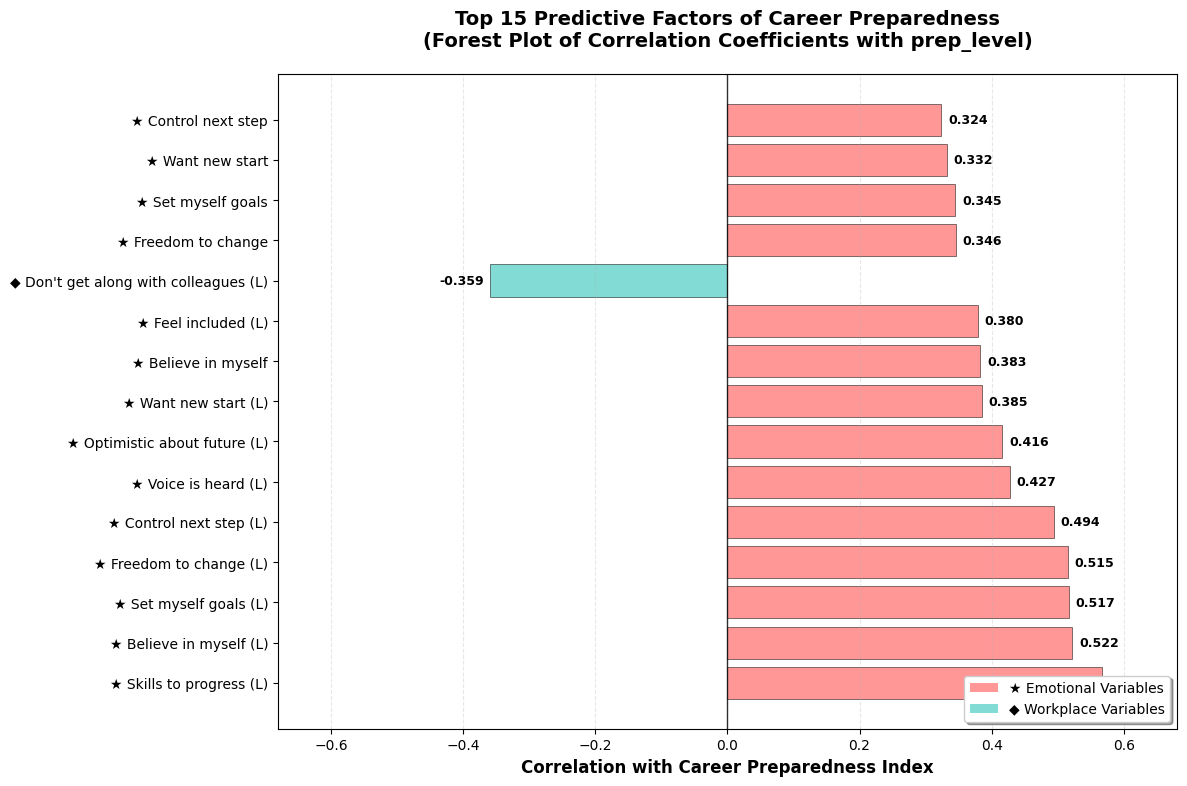

Forest plot shows the top 15 predictive factors ranked by correlation strength with Career Preparedness Index
Positive correlations indicate factors that increase preparedness
Negative correlations indicate factors that decrease preparedness
Note: All correlations are with prep_level (Career Preparedness Index, 0-10 scale)


In [13]:
# Create a professional forest plot of correlation coefficients with Career Preparedness Index
# This visualization is ideal for presentations showing key predictors

# Get top 15 predictors by absolute correlation with prep_level
top_predictors = corr_summary.head(15).copy()

# Create figure
fig, ax = plt.subplots(figsize=(12, 8))

# Define colors for variable types
plot_colors = [colors['emotional'] if vtype == 'Emotional' else colors['workplace'] 
               for vtype in top_predictors['Variable_Type']]

# Create horizontal forest plot
y_positions = np.arange(len(top_predictors))
correlations = top_predictors['Correlation'].values

# Plot correlation coefficients as horizontal bars
bars = ax.barh(y_positions, correlations, color=plot_colors, alpha=0.7, 
               edgecolor='black', linewidth=0.5)

# Add value labels on bars
for i, (bar, corr) in enumerate(zip(bars, correlations)):
    width = bar.get_width()
    label_x = width + (0.01 if width >= 0 else -0.01)
    ha = 'left' if width >= 0 else 'right'
    ax.text(label_x, bar.get_y() + bar.get_height()/2, f'{corr:.3f}', 
            ha=ha, va='center', fontweight='bold', fontsize=9)

# Customize the plot
ax.set_yticks(y_positions)
ax.set_yticklabels(top_predictors['Readable_Name'], fontsize=10)
ax.set_xlabel('Correlation with Career Preparedness Index', fontsize=12, fontweight='bold')
ax.set_title('Top 15 Predictive Factors of Career Preparedness\n(Forest Plot of Correlation Coefficients with prep_level)', 
             fontsize=14, fontweight='bold', pad=20)

# Add vertical line at zero
ax.axvline(x=0, color='black', linestyle='-', alpha=0.8, linewidth=1)

# Add grid for better readability
ax.grid(axis='x', alpha=0.3, linestyle='--')

# Add legend
legend_elements = [
    plt.Rectangle((0, 0), 1, 1, facecolor=colors['emotional'], alpha=0.7, label='★ Emotional Variables'),
    plt.Rectangle((0, 0), 1, 1, facecolor=colors['workplace'], alpha=0.7, label='◆ Workplace Variables')
]
ax.legend(handles=legend_elements, loc='lower right', frameon=True, fancybox=True, shadow=True)

# Set x-axis limits for better visualization
max_abs_corr = max(abs(correlations))
ax.set_xlim(-max_abs_corr * 1.2, max_abs_corr * 1.2)

plt.tight_layout()
plt.show()

print("Forest plot shows the top 15 predictive factors ranked by correlation strength with Career Preparedness Index")
print("Positive correlations indicate factors that increase preparedness")
print("Negative correlations indicate factors that decrease preparedness")
print(f"Note: All correlations are with prep_level (Career Preparedness Index, 0-10 scale)")

Predictive Power by Variable Type (Career Preparedness Index):
                            Abs_Correlation              Correlation         \
                                       mean    std count        mean    min   
Variable_Type Response_Type                                                   
Emotional     Fast_Choice             0.256  0.114    14       0.251 -0.031   
              Likert                  0.391  0.123    14       0.329 -0.228   
Workplace     Fast_Choice             0.132  0.052    11       0.045 -0.184   
              Likert                  0.225  0.087    11       0.027 -0.359   

                                    
                               max  
Variable_Type Response_Type         
Emotional     Fast_Choice    0.383  
              Likert         0.567  
Workplace     Fast_Choice    0.195  
              Likert         0.308  


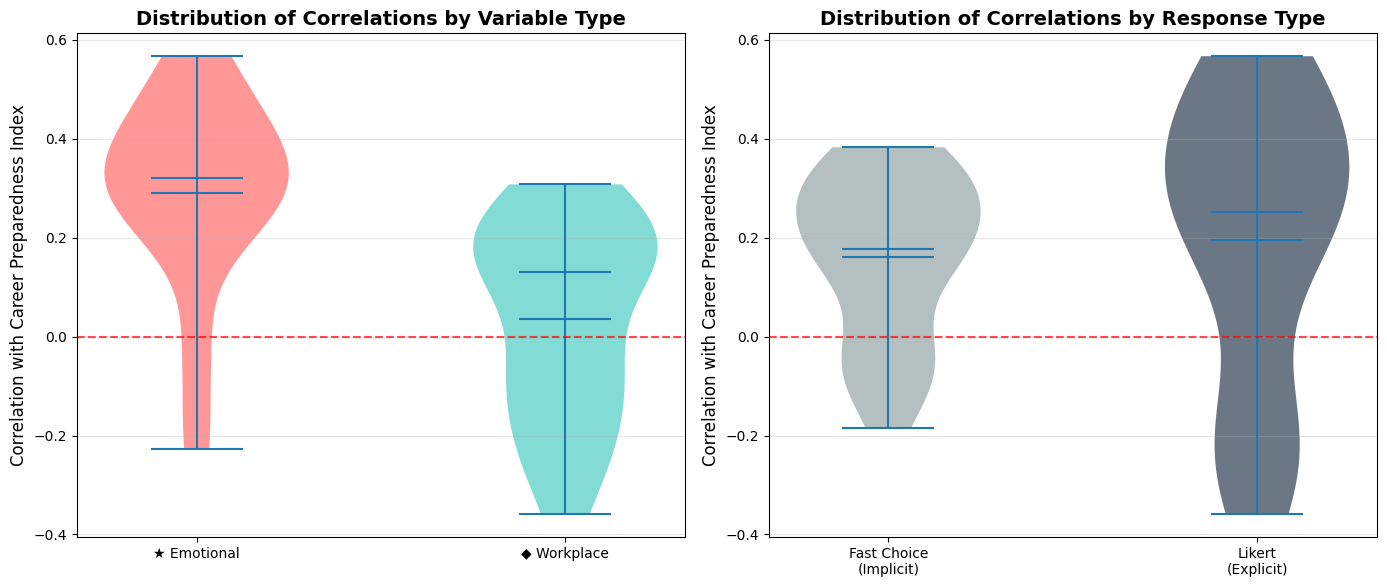


Summary Statistics (Career Preparedness Index):
★ Emotional variables - Mean |correlation|: 0.324
◆ Workplace variables - Mean |correlation|: 0.178
Likert - Mean |correlation|: 0.318
Fast_Choice - Mean |correlation|: 0.201


In [14]:
# Compare predictive power by variable type for Career Preparedness Index
type_summary = corr_summary.groupby(['Variable_Type', 'Response_Type']).agg({
    'Abs_Correlation': ['mean', 'std', 'count'],
    'Correlation': ['mean', 'min', 'max']
}).round(3)

print("Predictive Power by Variable Type (Career Preparedness Index):")
print(type_summary)

# Create enhanced violin plot comparing distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Check what variable types are available
available_var_types = corr_summary['Variable_Type'].unique()
available_response_types = corr_summary['Response_Type'].unique()

# Correlation distribution by variable type
if 'Emotional' in available_var_types and 'Workplace' in available_var_types:
    violin_parts = axes[0].violinplot([corr_summary[corr_summary['Variable_Type'] == 'Emotional']['Correlation'],
                                       corr_summary[corr_summary['Variable_Type'] == 'Workplace']['Correlation']], 
                                      positions=[1, 2], showmeans=True, showmedians=True)
    
    # Color the violin plots
    violin_parts['bodies'][0].set_facecolor(colors['emotional'])
    violin_parts['bodies'][1].set_facecolor(colors['workplace'])
    for pc in violin_parts['bodies']:
        pc.set_alpha(0.7)
    
    axes[0].set_xticks([1, 2])
    axes[0].set_xticklabels(['★ Emotional', '◆ Workplace'])
else:
    # Create bar plot if only one type available
    var_type_means = corr_summary.groupby('Variable_Type')['Abs_Correlation'].mean()
    bars = axes[0].bar(range(len(var_type_means)), var_type_means.values,
                       color=[colors['emotional'] if x == 'Emotional' else colors['workplace'] for x in var_type_means.index])
    axes[0].set_xticks(range(len(var_type_means)))
    axes[0].set_xticklabels([f'★ {x}' if x == 'Emotional' else f'◆ {x}' for x in var_type_means.index])

axes[0].set_ylabel('Correlation with Career Preparedness Index')
axes[0].set_title('Distribution of Correlations by Variable Type', fontweight='bold')
axes[0].axhline(y=0, color='red', linestyle='--', alpha=0.7)
axes[0].grid(axis='y', alpha=0.3)

# Correlation distribution by response type
if 'Fast_Choice' in available_response_types and 'Likert' in available_response_types:
    violin_parts2 = axes[1].violinplot([corr_summary[corr_summary['Response_Type'] == 'Fast_Choice']['Correlation'],
                                        corr_summary[corr_summary['Response_Type'] == 'Likert']['Correlation']], 
                                       positions=[1, 2], showmeans=True, showmedians=True)
    
    # Color the violin plots
    violin_parts2['bodies'][0].set_facecolor(colors['implicit'])
    violin_parts2['bodies'][1].set_facecolor(colors['explicit'])
    for pc in violin_parts2['bodies']:
        pc.set_alpha(0.7)
    
    axes[1].set_xticks([1, 2])
    axes[1].set_xticklabels(['Fast Choice\n(Implicit)', 'Likert\n(Explicit)'])
else:
    # Create bar plot if limited response types
    response_type_means = corr_summary.groupby('Response_Type')['Abs_Correlation'].mean()
    bars2 = axes[1].bar(range(len(response_type_means)), response_type_means.values,
                        color=[colors['implicit'] if 'Fast' in x else colors['explicit'] for x in response_type_means.index])
    axes[1].set_xticks(range(len(response_type_means)))
    axes[1].set_xticklabels(response_type_means.index, rotation=45)

axes[1].set_ylabel('Correlation with Career Preparedness Index')
axes[1].set_title('Distribution of Correlations by Response Type', fontweight='bold')
axes[1].axhline(y=0, color='red', linestyle='--', alpha=0.7)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Add summary statistics
print("\nSummary Statistics (Career Preparedness Index):")
for var_type in available_var_types:
    subset = corr_summary[corr_summary['Variable_Type'] == var_type]
    if len(subset) > 0:
        symbol = '★' if var_type == 'Emotional' else '◆'
        print(f"{symbol} {var_type} variables - Mean |correlation|: {subset['Abs_Correlation'].mean():.3f}")

for response_type in available_response_types:
    subset = corr_summary[corr_summary['Response_Type'] == response_type]
    if len(subset) > 0:
        print(f"{response_type} - Mean |correlation|: {subset['Abs_Correlation'].mean():.3f}")

In [15]:
# Generate key insights for Career Preparedness Index prediction
print("=== KEY INSIGHTS: MOST PREDICTIVE FACTORS OF CAREER PREPAREDNESS ===\n")

print("1. TOP EMOTIONAL PREDICTORS:")
top_emotional = corr_summary[corr_summary['Variable_Type'] == 'Emotional'].head(5)
for _, row in top_emotional.iterrows():
    print(f"   • {row['Readable_Name']}: r = {row['Correlation']:.3f}")

print("\n2. TOP WORKPLACE PREDICTORS:")
top_workplace = corr_summary[corr_summary['Variable_Type'] == 'Workplace'].head(5)
if len(top_workplace) > 0:
    for _, row in top_workplace.iterrows():
        print(f"   • {row['Readable_Name']}: r = {row['Correlation']:.3f}")
else:
    print("   • No workplace predictors available in current dataset")

print(f"\n3. OVERALL STRONGEST PREDICTOR:")
strongest = corr_summary.iloc[0]
print(f"   • {strongest['Readable_Name']}")
print(f"   • Correlation with prep_level: {strongest['Correlation']:.3f}")
print(f"   • Type: {strongest['Variable_Type']}")

print(f"\n4. RESPONSE TYPE COMPARISON:")
available_response_types = corr_summary['Response_Type'].unique()
for response_type in available_response_types:
    subset = corr_summary[corr_summary['Response_Type'] == response_type]
    if len(subset) > 0:
        mean_corr = subset['Abs_Correlation'].mean()
        print(f"   • {response_type} average |correlation| with prep_level: {mean_corr:.3f}")

print(f"\n5. VARIABLE TYPE COMPARISON:")
available_var_types = corr_summary['Variable_Type'].unique()
for var_type in available_var_types:
    subset = corr_summary[corr_summary['Variable_Type'] == var_type]
    if len(subset) > 0:
        mean_corr = subset['Abs_Correlation'].mean()
        symbol = '★' if var_type == 'Emotional' else '◆'
        print(f"   • {symbol} {var_type} variables average |correlation| with prep_level: {mean_corr:.3f}")

print(f"\n6. CAREER PREPAREDNESS INDEX SUMMARY:")
print(f"   • Target variable: prep_level (0-10 scale)")
print(f"   • Mean preparedness level: {data['prep_level'].mean():.2f} ± {data['prep_level'].std():.2f}")
print(f"   • Range: {data['prep_level'].min():.1f} to {data['prep_level'].max():.1f}")
print(f"   • Sample size: {data['prep_level'].count():,} respondents")

=== KEY INSIGHTS: MOST PREDICTIVE FACTORS OF CAREER PREPAREDNESS ===

1. TOP EMOTIONAL PREDICTORS:
   • ★ Skills to progress (L): r = 0.567
   • ★ Believe in myself (L): r = 0.522
   • ★ Set myself goals (L): r = 0.517
   • ★ Freedom to change (L): r = 0.515
   • ★ Control next step (L): r = 0.494

2. TOP WORKPLACE PREDICTORS:
   • ◆ Don't get along with colleagues (L): r = -0.359
   • ◆ Can use skills (L): r = 0.308
   • ◆ Culture is toxic (L): r = -0.254
   • ◆ Learning opportunities (L): r = 0.252
   • ◆ Manager is poor (L): r = -0.249

3. OVERALL STRONGEST PREDICTOR:
   • ★ Skills to progress (L)
   • Correlation with prep_level: 0.567
   • Type: Emotional

4. RESPONSE TYPE COMPARISON:
   • Likert average |correlation| with prep_level: 0.318
   • Fast_Choice average |correlation| with prep_level: 0.201

5. VARIABLE TYPE COMPARISON:
   • ★ Emotional variables average |correlation| with prep_level: 0.324
   • ◆ Workplace variables average |correlation| with prep_level: 0.178

6. CARE

#### Part B: Comparing implicit vs. explicit global drivers of preparedness

In [16]:
# Create matched pairs of fast choice (implicit) vs Likert (explicit) variables
emotional_pairs = [
    ('es_ftra_des', 'el_ltra_des', 'Want new start'),
    ('es_ftra_aut', 'el_ltra_aut', 'Freedom to change'),
    ('es_fcnt_com', 'el_lcnt_com', 'Comfortable where I am'),
    ('es_fcnt_psy', 'el_lcnt_psy', 'Voice is heard'),
    ('es_fcon_soc', 'el_lcon_soc', 'Others influence decisions'),
    ('es_fbal_anx', 'el_lbal_anx', 'Anxious about change'),
    ('es_fres_fin', 'el_lres_fin', 'Financially motivated'),
    ('es_fcont_imp', 'el_lcont_imp', 'Believe in myself'),
    ('es_fjou_opt', 'el_ljou_opt', 'Optimistic about future'),
    ('es_fcon_inc', 'el_lcon_inc', 'Feel included'),
    ('es_fbal_sat', 'el_lbal_sat', 'Happy where I am'),
    ('es_fres_ski', 'el_lres_ski', 'Skills to progress'),
    ('es_fcont_con', 'el_lcont_con', 'Control next step'),
    ('es_fjou_pro', 'el_ljou_pro', 'Set myself goals')
]

workplace_pairs = [
    ('wfs_fuse_skills', 'wfl_luse_skills', 'Can use skills'),
    ('wfs_flearn_dev', 'wfl_llearn_dev', 'Learning opportunities'),
    ('wfs_fcarprom', 'wfl_lcarprom_d', 'Can grow here'),
    ('wfs_fmean_full', 'wfl_lmean_full', 'Job meaningful'),
    ('wfs_fpoorman', 'wfl_lpoorman', 'Manager is poor'),
    ('wfs_ftoxic', 'wfl_ltoxic', 'Culture is toxic'),
    ('wfs_fexcess_wk', 'wfl_lexcess_wk', 'Working too hard'),
    ('wfs_fcollea', 'wfl_lcollea', 'Don\'t get along with colleagues'),
    ('wfs_fwellcomp', 'wfl_lwellcomp', 'Well compensated'),
    ('wfs_ffin_fair', 'wfl_lfin_lair', 'Salary unfair vs colleagues'),
    ('wfs_fenjhyb', 'wfl_lenjhyb', 'Enjoy hybrid working')
]

all_pairs = emotional_pairs + workplace_pairs

print(f"Emotional factor pairs: {len(emotional_pairs)}")
print(f"Workplace factor pairs: {len(workplace_pairs)}")
print(f"Total matched pairs: {len(all_pairs)}")

Emotional factor pairs: 14
Workplace factor pairs: 11
Total matched pairs: 25


In [17]:
# Calculate correlations for each response type with Career Preparedness Index
correlation_comparison = []

for fast_var, likert_var, label in all_pairs:
    # Correlations with Career Preparedness Index (prep_level)
    fast_prep_corr = data[[fast_var, 'prep_level']].corr().iloc[0,1]
    likert_prep_corr = data[[likert_var, 'prep_level']].corr().iloc[0,1]
    
    # Cross-correlations between response types
    cross_corr = data[[fast_var, likert_var]].corr().iloc[0,1]
    
    # Variable type
    var_type = 'Emotional' if fast_var.startswith('es_') else 'Workplace'
    
    correlation_comparison.append({
        'Factor': label,
        'Variable_Type': var_type,
        'Fast_Choice_Var': fast_var,
        'Likert_Var': likert_var,
        'Fast_Choice_Corr': fast_prep_corr,
        'Likert_Corr': likert_prep_corr,
        'Cross_Correlation': cross_corr,
        'Correlation_Diff': abs(fast_prep_corr - likert_prep_corr),
        'Stronger_Predictor': 'Fast_Choice' if abs(fast_prep_corr) > abs(likert_prep_corr) else 'Likert'
    })

comparison_df = pd.DataFrame(correlation_comparison)
comparison_df = comparison_df.sort_values('Correlation_Diff', ascending=False)

print("Top 10 Factors with Largest Implicit vs Explicit Differences (prep_level correlations):")
print(comparison_df[['Factor', 'Variable_Type', 'Fast_Choice_Corr', 'Likert_Corr', 
                    'Correlation_Diff', 'Stronger_Predictor']].head(10))

Top 10 Factors with Largest Implicit vs Explicit Differences (prep_level correlations):
                             Factor Variable_Type  Fast_Choice_Corr  \
11               Skills to progress     Emotional          0.311016   
9                     Feel included     Emotional          0.175926   
4        Others influence decisions     Emotional         -0.007388   
5              Anxious about change     Emotional         -0.030765   
19                 Culture is toxic     Workplace         -0.068210   
3                    Voice is heard     Emotional          0.244908   
21  Don't get along with colleagues     Workplace         -0.183869   
13                 Set myself goals     Emotional          0.344908   
12                Control next step     Emotional          0.323942   
1                 Freedom to change     Emotional          0.345566   

    Likert_Corr  Correlation_Diff Stronger_Predictor  
11     0.567131          0.256115             Likert  
9      0.379637     

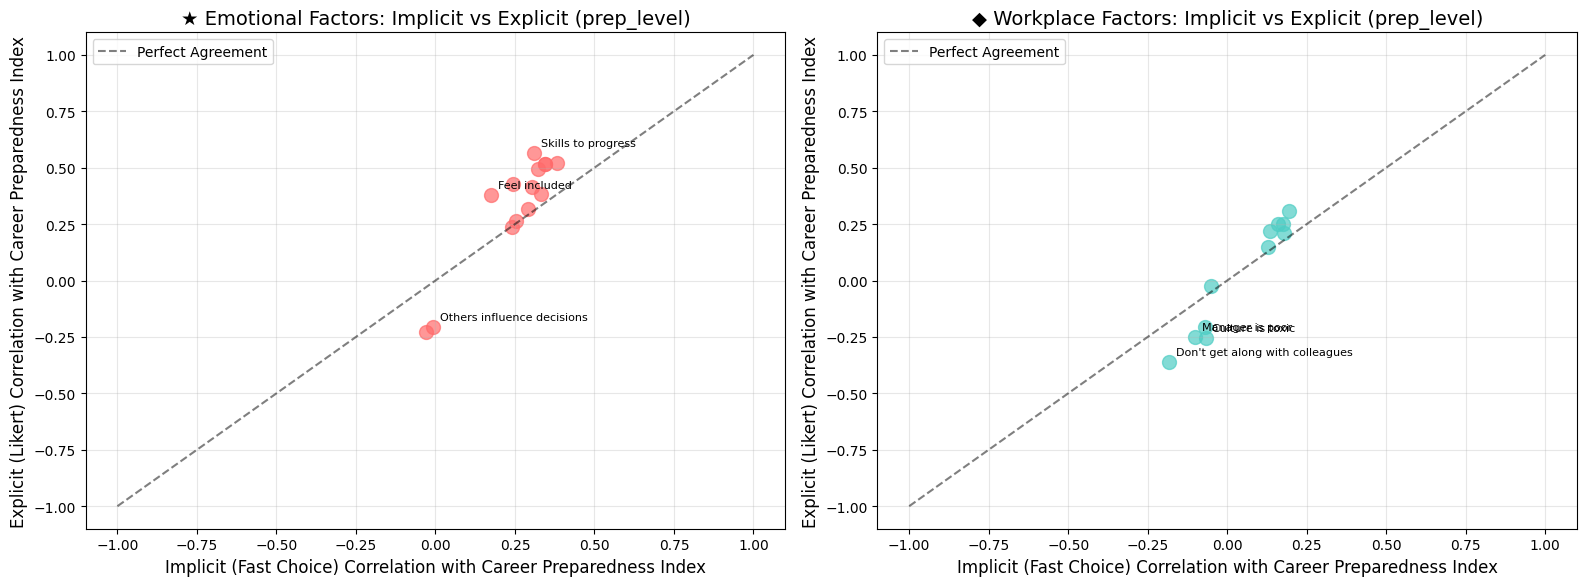

Note: All correlations are with prep_level (Career Preparedness Index, 0-10 scale)


In [18]:
# Create scatter plot comparing implicit vs explicit correlations with Career Preparedness Index
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Emotional factors
emotional_data = comparison_df[comparison_df['Variable_Type'] == 'Emotional']
axes[0].scatter(emotional_data['Fast_Choice_Corr'], emotional_data['Likert_Corr'], 
               alpha=0.7, s=100, color=colors['emotional'])
axes[0].plot([-1, 1], [-1, 1], 'k--', alpha=0.5, label='Perfect Agreement')
axes[0].set_xlabel('Implicit (Fast Choice) Correlation with Career Preparedness Index')
axes[0].set_ylabel('Explicit (Likert) Correlation with Career Preparedness Index')
axes[0].set_title('★ Emotional Factors: Implicit vs Explicit (prep_level)')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# Add annotations for most divergent points
for _, row in emotional_data.head(3).iterrows():
    axes[0].annotate(row['Factor'], 
                    (row['Fast_Choice_Corr'], row['Likert_Corr']),
                    xytext=(5, 5), textcoords='offset points', fontsize=8)

# Workplace factors
workplace_data = comparison_df[comparison_df['Variable_Type'] == 'Workplace']
if len(workplace_data) > 0:
    axes[1].scatter(workplace_data['Fast_Choice_Corr'], workplace_data['Likert_Corr'], 
                   alpha=0.7, s=100, color=colors['workplace'])
    axes[1].plot([-1, 1], [-1, 1], 'k--', alpha=0.5, label='Perfect Agreement')
    
    # Add annotations for most divergent points
    for _, row in workplace_data.head(3).iterrows():
        axes[1].annotate(row['Factor'], 
                        (row['Fast_Choice_Corr'], row['Likert_Corr']),
                        xytext=(5, 5), textcoords='offset points', fontsize=8)
else:
    axes[1].text(0.5, 0.5, 'No Workplace Data Available', 
                ha='center', va='center', transform=axes[1].transAxes, fontsize=14)

axes[1].set_xlabel('Implicit (Fast Choice) Correlation with Career Preparedness Index')
axes[1].set_ylabel('Explicit (Likert) Correlation with Career Preparedness Index')
axes[1].set_title('◆ Workplace Factors: Implicit vs Explicit (prep_level)')
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()

print("Note: All correlations are with prep_level (Career Preparedness Index, 0-10 scale)")

In [19]:
# Commenting this out as it doesn't add much in the end

# # Examine how well implicit and explicit measures agree with each other
# cross_corr_analysis = comparison_df.groupby('Variable_Type').agg({
#     'Cross_Correlation': ['mean', 'std', 'min', 'max'],
#     'Correlation_Diff': ['mean', 'std', 'min', 'max']
# }).round(3)

# print("Cross-Correlation Analysis (How well do implicit & explicit measures agree?):")
# print(cross_corr_analysis)

# # Create enhanced violin plot of cross-correlations with consistent colors
# fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# # Cross-correlations by variable type with custom colors
# emotional_cross = comparison_df[comparison_df['Variable_Type'] == 'Emotional']['Cross_Correlation']
# workplace_cross = comparison_df[comparison_df['Variable_Type'] == 'Workplace']['Cross_Correlation']

# violin_parts1 = axes[0].violinplot([emotional_cross, workplace_cross], 
#                                    positions=[1, 2], showmeans=True, showmedians=True)

# violin_parts1['bodies'][0].set_facecolor(colors['emotional'])
# violin_parts1['bodies'][1].set_facecolor(colors['workplace'])
# for pc in violin_parts1['bodies']:
#     pc.set_alpha(0.7)

# axes[0].set_xticks([1, 2])
# axes[0].set_xticklabels(['★ Emotional', '◆ Workplace'])
# axes[0].set_ylabel('Cross-Correlation')
# axes[0].set_title('Agreement Between Implicit & Explicit Measures', fontweight='bold')
# axes[0].axhline(y=0.7, color='red', linestyle='--', alpha=0.7, label='Strong Agreement')
# axes[0].grid(axis='y', alpha=0.3)
# axes[0].legend()

# # Correlation differences by variable type
# emotional_diff = comparison_df[comparison_df['Variable_Type'] == 'Emotional']['Correlation_Diff']
# workplace_diff = comparison_df[comparison_df['Variable_Type'] == 'Workplace']['Correlation_Diff']

# violin_parts2 = axes[1].violinplot([emotional_diff, workplace_diff], 
#                                    positions=[1, 2], showmeans=True, showmedians=True)

# violin_parts2['bodies'][0].set_facecolor(colors['emotional'])
# violin_parts2['bodies'][1].set_facecolor(colors['workplace'])
# for pc in violin_parts2['bodies']:
#     pc.set_alpha(0.7)

# axes[1].set_xticks([1, 2])
# axes[1].set_xticklabels(['★ Emotional', '◆ Workplace'])
# axes[1].set_ylabel('Absolute Difference in Correlations')
# axes[1].set_title('Difference in Predictive Power\n(|Fast Choice| - |Likert|)', fontweight='bold')
# axes[1].axhline(y=0, color='red', linestyle='--', alpha=0.7)
# axes[1].grid(axis='y', alpha=0.3)

# plt.tight_layout()
# plt.show()

In [20]:
# Factors where implicit and explicit measures tell different stories
high_divergence = comparison_df[comparison_df['Correlation_Diff'] > 0.1]
low_agreement = comparison_df[comparison_df['Cross_Correlation'] < 0.5]

print("=== FACTORS WITH HIGH IMPLICIT/EXPLICIT DIVERGENCE ===")
print("(Where fast choice and Likert give different signals about preparedness)\n")

if len(high_divergence) > 0:
    print("High Divergence Factors:")
    for _, row in high_divergence.iterrows():
        print(f"• {row['Factor']} ({row['Variable_Type']})")
        print(f"  Fast Choice correlation: {row['Fast_Choice_Corr']:.3f}")
        print(f"  Likert correlation: {row['Likert_Corr']:.3f}")
        print(f"  Difference: {row['Correlation_Diff']:.3f}")
        print(f"  Stronger predictor: {row['Stronger_Predictor']}")
        print()

print("=== FACTORS WITH LOW IMPLICIT/EXPLICIT AGREEMENT ===")
print("(Where people respond differently on fast choice vs Likert)\n")

if len(low_agreement) > 0:
    print("Low Agreement Factors:")
    for _, row in low_agreement.iterrows():
        print(f"• {row['Factor']} ({row['Variable_Type']})")
        print(f"  Cross-correlation: {row['Cross_Correlation']:.3f}")
        print(f"  This suggests implicit/explicit responses measure different aspects")
        print()

=== FACTORS WITH HIGH IMPLICIT/EXPLICIT DIVERGENCE ===
(Where fast choice and Likert give different signals about preparedness)

High Divergence Factors:
• Skills to progress (Emotional)
  Fast Choice correlation: 0.311
  Likert correlation: 0.567
  Difference: 0.256
  Stronger predictor: Likert

• Feel included (Emotional)
  Fast Choice correlation: 0.176
  Likert correlation: 0.380
  Difference: 0.204
  Stronger predictor: Likert

• Others influence decisions (Emotional)
  Fast Choice correlation: -0.007
  Likert correlation: -0.207
  Difference: 0.199
  Stronger predictor: Likert

• Anxious about change (Emotional)
  Fast Choice correlation: -0.031
  Likert correlation: -0.228
  Difference: 0.197
  Stronger predictor: Likert

• Culture is toxic (Workplace)
  Fast Choice correlation: -0.068
  Likert correlation: -0.254
  Difference: 0.185
  Stronger predictor: Likert

• Voice is heard (Emotional)
  Fast Choice correlation: 0.245
  Likert correlation: 0.427
  Difference: 0.182
  Stron

In [21]:
# from scipy.stats import ttest_rel, wilcoxon

# # Compare absolute correlations between fast choice and Likert
# fast_choice_corrs = comparison_df['Fast_Choice_Corr'].abs()
# likert_corrs = comparison_df['Likert_Corr'].abs()

# # Paired t-test
# t_stat, t_pval = ttest_rel(fast_choice_corrs, likert_corrs)

# # Wilcoxon signed rank test (non-parametric alternative)
# w_stat, w_pval = wilcoxon(fast_choice_corrs, likert_corrs)

# print("=== STATISTICAL COMPARISON OF PREDICTIVE POWER ===\n")

# print(f"Fast Choice mean |correlation|: {fast_choice_corrs.mean():.3f} ± {fast_choice_corrs.std():.3f}")
# print(f"Likert mean |correlation|: {likert_corrs.mean():.3f} ± {likert_corrs.std():.3f}")
# print(f"Mean difference: {(fast_choice_corrs - likert_corrs).mean():.3f}")

# print(f"\nPaired t-test: t = {t_stat:.3f}, p = {t_pval:.3f}")
# print(f"Wilcoxon test: W = {w_stat:.3f}, p = {w_pval:.3f}")

# if t_pval < 0.05:
#     stronger = "Fast Choice" if fast_choice_corrs.mean() > likert_corrs.mean() else "Likert"
#     print(f"\n*** SIGNIFICANT DIFFERENCE: {stronger} measures are stronger predictors ***")
# else:
#     print(f"\n*** NO SIGNIFICANT DIFFERENCE in predictive power ***")

# # Breakdown by variable type
# for var_type in ['Emotional', 'Workplace']:
#     subset = comparison_df[comparison_df['Variable_Type'] == var_type]
#     fast_subset = subset['Fast_Choice_Corr'].abs()
#     likert_subset = subset['Likert_Corr'].abs()
    
#     print(f"\n{var_type} Variables:")
#     print(f"  Fast Choice: {fast_subset.mean():.3f} ± {fast_subset.std():.3f}")
#     print(f"  Likert: {likert_subset.mean():.3f} ± {likert_subset.std():.3f}")
#     print(f"  Difference: {(fast_subset - likert_subset).mean():.3f}")

In [22]:
print("=== KEY INSIGHTS: IMPLICIT vs EXPLICIT GLOBAL DRIVERS (prep_level) ===\n")

# Overall patterns
overall_fast_mean = comparison_df['Fast_Choice_Corr'].abs().mean()
overall_likert_mean = comparison_df['Likert_Corr'].abs().mean()
overall_cross_corr = comparison_df['Cross_Correlation'].mean()

print("1. OVERALL PATTERNS (Career Preparedness Index correlations):")
print(f"   • Average implicit (fast choice) predictive power: {overall_fast_mean:.3f}")
print(f"   • Average explicit (Likert) predictive power: {overall_likert_mean:.3f}")
print(f"   • Average agreement between methods: {overall_cross_corr:.3f}")

# Strongest predictors by method
strongest_fast = comparison_df.loc[comparison_df['Fast_Choice_Corr'].abs().idxmax()]
strongest_likert = comparison_df.loc[comparison_df['Likert_Corr'].abs().idxmax()]

print(f"\n2. STRONGEST PREDICTORS OF CAREER PREPAREDNESS:")
print(f"   • Strongest implicit predictor: {strongest_fast['Factor']} (r = {strongest_fast['Fast_Choice_Corr']:.3f})")
print(f"   • Strongest explicit predictor: {strongest_likert['Factor']} (r = {strongest_likert['Likert_Corr']:.3f})")

# Method preference
fast_wins = len(comparison_df[comparison_df['Stronger_Predictor'] == 'Fast_Choice'])
likert_wins = len(comparison_df[comparison_df['Stronger_Predictor'] == 'Likert'])

print(f"\n3. METHOD EFFECTIVENESS:")
print(f"   • Factors where fast choice is stronger: {fast_wins}/{len(comparison_df)} ({100*fast_wins/len(comparison_df):.0f}%)")
print(f"   • Factors where Likert is stronger: {likert_wins}/{len(comparison_df)} ({100*likert_wins/len(comparison_df):.0f}%)")

# Domain differences
emotional_cross_corr = comparison_df[comparison_df['Variable_Type'] == 'Emotional']['Cross_Correlation'].mean()
workplace_cross_corr = comparison_df[comparison_df['Variable_Type'] == 'Workplace']['Cross_Correlation'].mean()

print(f"\n4. DOMAIN-SPECIFIC PATTERNS:")
print(f"   • Emotional factors: implicit/explicit agreement = {emotional_cross_corr:.3f}")
if not pd.isna(workplace_cross_corr):
    print(f"   • Workplace factors: implicit/explicit agreement = {workplace_cross_corr:.3f}")
else:
    print(f"   • Workplace factors: No data available")

# Practical implications
print(f"\n5. PRACTICAL IMPLICATIONS FOR CAREER PREPAREDNESS ASSESSMENT:")
if overall_cross_corr > 0.7:
    print(f"   • High agreement suggests both methods capture similar constructs")
    print(f"   • Either method could be used with confidence for prep_level prediction")
elif overall_cross_corr < 0.5:
    print(f"   • Low agreement suggests methods capture different aspects")
    print(f"   • Consider using both methods for comprehensive career preparedness assessment")
else:
    print(f"   • Moderate agreement suggests some overlap but also unique information")
    print(f"   • Fast choice may capture unconscious/automatic responses to career readiness")
    print(f"   • Likert may capture conscious/deliberative responses to career preparedness")

print(f"\n6. TARGET VARIABLE DETAILS:")
print(f"   • All correlations computed with prep_level (Career Preparedness Index)")
print(f"   • Scale: 0-10 continuous measure of career readiness")
print(f"   • Mean: {data['prep_level'].mean():.2f}, SD: {data['prep_level'].std():.2f}")

=== KEY INSIGHTS: IMPLICIT vs EXPLICIT GLOBAL DRIVERS (prep_level) ===

1. OVERALL PATTERNS (Career Preparedness Index correlations):
   • Average implicit (fast choice) predictive power: 0.201
   • Average explicit (Likert) predictive power: 0.318
   • Average agreement between methods: 0.365

2. STRONGEST PREDICTORS OF CAREER PREPAREDNESS:
   • Strongest implicit predictor: Believe in myself (r = 0.383)
   • Strongest explicit predictor: Skills to progress (r = 0.567)

3. METHOD EFFECTIVENESS:
   • Factors where fast choice is stronger: 2/25 (8%)
   • Factors where Likert is stronger: 23/25 (92%)

4. DOMAIN-SPECIFIC PATTERNS:
   • Emotional factors: implicit/explicit agreement = 0.373
   • Workplace factors: implicit/explicit agreement = 0.355

5. PRACTICAL IMPLICATIONS FOR CAREER PREPAREDNESS ASSESSMENT:
   • Low agreement suggests methods capture different aspects
   • Consider using both methods for comprehensive career preparedness assessment

6. TARGET VARIABLE DETAILS:
   • All

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import numpy as np
import pandas as pd

# Define our predictor sets
explicit_emotional = [col for col in data.columns if col.startswith('el_') and col != 'el_lgen']
explicit_workplace = [col for col in data.columns if col.startswith('wfl_')]
all_explicit = explicit_emotional + explicit_workplace

implicit_emotional = [col for col in data.columns if col.startswith('es_') and col != 'es_fgen']
implicit_workplace = [col for col in data.columns if col.startswith('wfs_')]
all_implicit = implicit_emotional + implicit_workplace

# Career Preparedness target
target_prep = 'prep_level'  # Career Preparedness Index (0-10 scale)

print(f"Explicit predictors: {len(all_explicit)}")
print(f"Implicit predictors: {len(all_implicit)}")
print(f"Total potential predictors: {len(all_explicit) + len(all_implicit)}")
print(f"Target: {target_prep} (Career Preparedness Index)")

# Create clean dataset for analysis
analysis_vars = all_explicit + all_implicit + [target_prep]
clean_data = data[analysis_vars].dropna()
print(f"Complete cases for analysis: {len(clean_data)} out of {len(data)} ({100*len(clean_data)/len(data):.1f}%)")
print(f"Target variable mean: {clean_data[target_prep].mean():.2f} ± {clean_data[target_prep].std():.2f}")

Explicit predictors: 25
Implicit predictors: 25
Total potential predictors: 50
Target: prep_level (Career Preparedness Index)
Complete cases for analysis: 4194 out of 4211 (99.6%)
Target variable mean: 7.47 ± 1.55
Complete cases for analysis: 4194 out of 4211 (99.6%)
Target variable mean: 7.47 ± 1.55


In [ ]:
def hierarchical_regression(X_base, X_additional, y, model_type='linear'):
    """Perform hierarchical regression to test incremental validity"""
    
    if model_type == 'linear':
        model = LinearRegression()
    else:
        model = RandomForestRegressor(n_estimators=100, random_state=42)
    
    # Step 1: Baseline model with explicit predictors only
    model.fit(X_base, y)
    r2_base = model.score(X_base, y)
    
    # Step 2: Full model with implicit predictors added
    X_full = np.column_stack([X_base, X_additional])
    model.fit(X_full, y)
    r2_full = model.score(X_full, y)
    
    # Calculate incremental R²
    incremental_r2 = r2_full - r2_base
    
    return {
        'r2_base': r2_base,
        'r2_full': r2_full,
        'incremental_r2': incremental_r2,
        'percentage_improvement': (incremental_r2 / r2_base) * 100 if r2_base > 0 else 0
    }

# Test incremental validity for Career Preparedness Index
print("=== INCREMENTAL VALIDITY FOR CAREER PREPAREDNESS INDEX ===\n")

X_explicit = clean_data[all_explicit]
X_implicit = clean_data[all_implicit]
y_prep = clean_data[target_prep]

print(f"Target: {target_prep} (Career Preparedness Index, 0-10 scale)")
print(f"Sample size: {len(clean_data):,} respondents")
print(f"Target mean: {y_prep.mean():.2f} ± {y_prep.std():.2f}")

# Linear regression results
linear_results = hierarchical_regression(X_explicit, X_implicit, y_prep, 'linear')
print(f"\nLinear Regression Results:")
print(f"  Explicit only R²: {linear_results['r2_base']:.4f}")
print(f"  Explicit + Implicit R²: {linear_results['r2_full']:.4f}")
print(f"  Incremental R²: {linear_results['incremental_r2']:.4f}")
print(f"  Percentage improvement: {linear_results['percentage_improvement']:.1f}%")

# Random Forest results
rf_results = hierarchical_regression(X_explicit, X_implicit, y_prep, 'rf')
print(f"\nRandom Forest Results:")
print(f"  Explicit only R²: {rf_results['r2_base']:.4f}")
print(f"  Explicit + Implicit R²: {rf_results['r2_full']:.4f}")
print(f"  Incremental R²: {rf_results['incremental_r2']:.4f}")
print(f"  Percentage improvement: {rf_results['percentage_improvement']:.1f}%")

print(f"\n=== INTERPRETATION ===")
if linear_results['incremental_r2'] > 0.01:
    print(f"✓ Implicit measures add meaningful predictive value to Career Preparedness prediction")
    print(f"✓ Including both explicit and implicit measures improves model performance")
else:
    print(f"→ Implicit measures provide minimal additional predictive value")
    print(f"→ Explicit measures may be sufficient for Career Preparedness prediction")

=== INCREMENTAL VALIDITY FOR FAST CHOICE PREPAREDNESS ===

Linear Regression Results:
  Explicit only R²: 0.1477
  Explicit + Implicit R²: 0.2417
  Incremental R²: 0.0940
  Percentage improvement: 63.7%

Random Forest Results:
  Explicit only R²: 0.8715
  Explicit + Implicit R²: 0.8901
  Incremental R²: 0.0186
  Percentage improvement: 2.1%
